In [5]:
import numpy as np
from scipy import misc
from matplotlib import pylab as plt
import matplotlib.cm as cm
import imageio
%matplotlib inline


from PIL import Image
im = Image.open('lisa.jpg', 'r')
width, height = im.size
pixel_values = np.asarray(list(im.getdata()))
print(pixel_values.shape)

all_index = np.asarray([[[i,j] for i in range(width)] for j in range(height)])
print(all_index.shape)

[ 109402  685110  564785 1396096  387416 1220082 1580085  585034  201498
  202621]


In [87]:
sample_index = np.random.choice(width*height, 5000)
print(sample_index[:10])
sample = []
for idx in sample_index:
    sample.append(pixel_values[idx])
print(sample[:10])

[ 15992 297462 106154 262596 239659 505960 428458 351172 212244  92008]
[array([107, 123,  76]), array([86, 44,  6]), array([134, 143,  88]), array([75, 50, 30]), array([58, 57, 29]), array([ 7,  5, 26]), array([193, 147,  70]), array([64, 50, 50]), array([44, 25, 21]), array([163, 166, 121])]


In [88]:
sample_tuple = []
for idx in sample_index:
    y = int(idx/width)-1
    x = idx%width-1
    sample_tuple.append([x,y])
print(sample_tuple[:10])

[[287, 25], [293, 491], [453, 174], [459, 433], [474, 395], [411, 836], [221, 708], [247, 580], [239, 350], [199, 151]]


[[0.41960784 0.48235294 0.29803922]
 [0.3372549  0.17254902 0.02352941]
 [0.5254902  0.56078431 0.34509804]
 [0.29411765 0.19607843 0.11764706]
 [0.22745098 0.22352941 0.11372549]
 [0.02745098 0.01960784 0.10196078]
 [0.75686275 0.57647059 0.2745098 ]
 [0.25098039 0.19607843 0.19607843]
 [0.17254902 0.09803922 0.08235294]
 [0.63921569 0.65098039 0.4745098 ]]
(900, 604)
[0.4392156862745098, 0.20392156862745098, 0.5254901960784314, 0.21568627450980393, 0.21176470588235294, 0.027450980392156862, 0.592156862745098, 0.21176470588235294, 0.11764705882352941, 0.6235294117647059]
[0.4196078431372549, 0.33725490196078434, 0.5254901960784314, 0.29411764705882354, 0.22745098039215686, 0.027450980392156862, 0.7568627450980392, 0.25098039215686274, 0.17254901960784313, 0.6392156862745098]


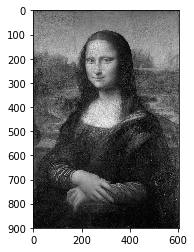

In [89]:
#preprocessing output
#rgb
sn = np.array(sample)/255
print(sn[:10])

#greyscale
imgrey = np.array(im.convert('LA'))[:,:,0]/255 #wrong, should be avg rgb
print(imgrey.shape)
plt.imshow(imgrey, cmap='gray')
sgrey = []
for idx in sample_index:
    sgrey.append(imgrey.flatten()[idx])
print(sgrey[:10])
 
#single channel
sr = [s[0]/255 for s in sample]
print(sr[:10])
sg = [s[1]/255 for s in sample]
sb = [s[2]/255 for s in sample]

In [93]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(random_state=0, n_estimators=100)
#use rgb output
regr.fit(np.asarray(sample_tuple), sn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [94]:
pred = regr.predict(all_index.reshape(-1,2))

(604, 900, 3)


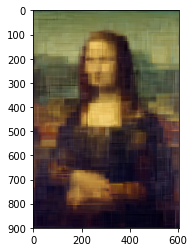

In [95]:
print(np.asarray(pred).reshape(width, height, -1).shape)
plt.imshow(np.asarray(pred).reshape(height, width, -1))

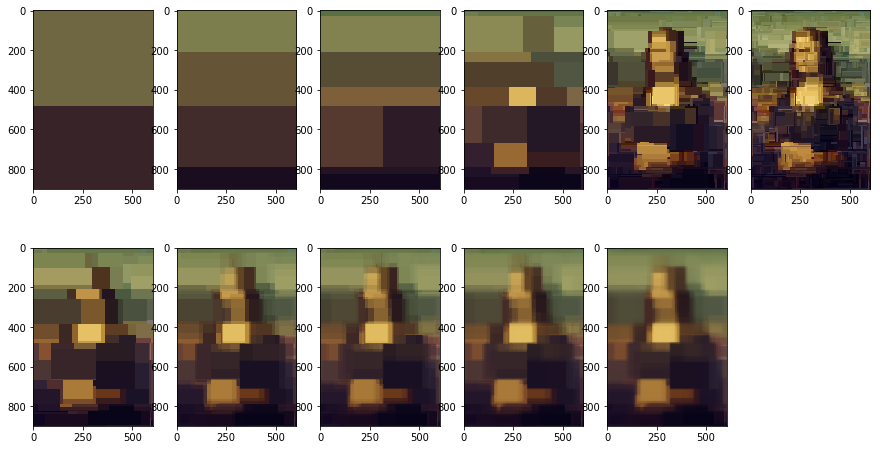

In [127]:
#experiments
regrs = []
for d in [1,2,3,5,10,15]:
    #depth
    regrs.append(RandomForestRegressor(max_depth=d, random_state=0, n_estimators=1))
for t in [1,3,5,10,100]:
    #trees
    regrs.append(RandomForestRegressor(max_depth=7, random_state=0, n_estimators=t))

f, axs = plt.subplots(2,2,figsize=(15,8))
for i in range(len(regrs)):
    regrs[i].fit(np.asarray(sample_tuple), sn)
    p = regrs[i].predict(all_index.reshape(-1,2))
    plt.subplot(2, 6, i+1)
    plt.imshow(np.asarray(p).reshape(height, width, -1))



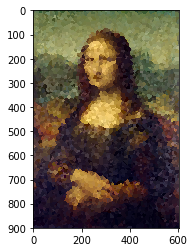

In [103]:
#knn baseline
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1)
p = knn.fit(np.asarray(sample_tuple), sn).predict(all_index.reshape(-1,2))
plt.imshow(np.asarray(p).reshape(height, width, -1))

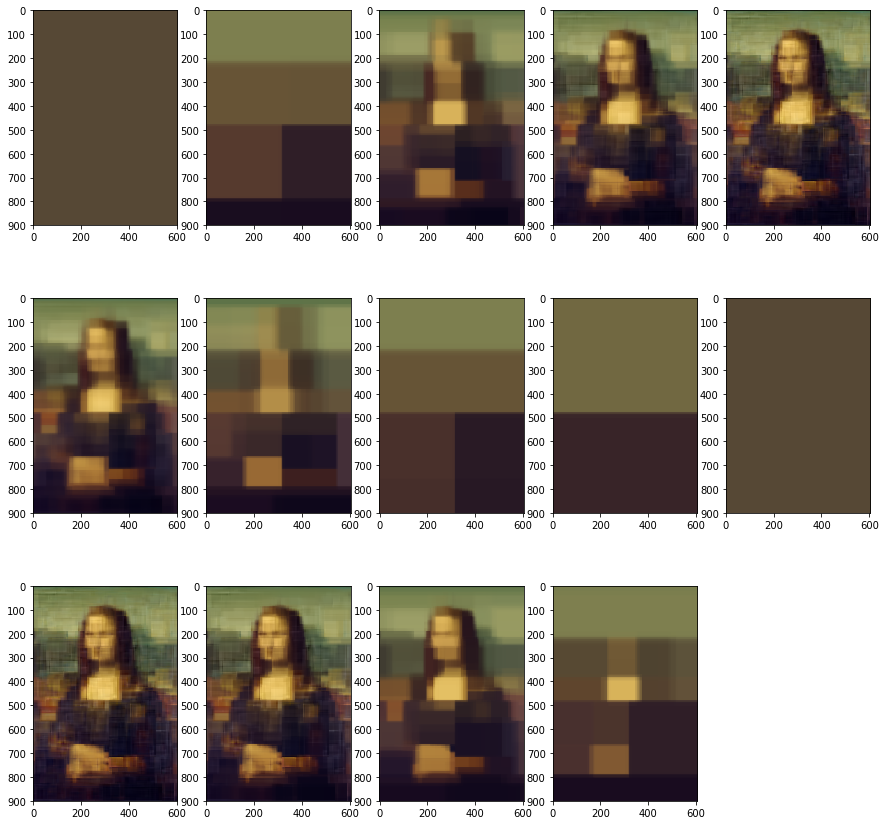

In [122]:
# pruning
# already done n_estimators and max_depth
# min_samples_split(proportional to max_depth), max_leaf_nodes(proportion to min_samples_leaf)
# min_samples_leaf(...all proportional to each other)
# max_features(but only 2), didn't try

regrs_new = []
for mss in [5000,1000,100,10,2]:
    regrs_new.append(RandomForestRegressor(min_samples_split=mss, random_state=0, n_estimators=100))
for msl in [10,100,500,1000,5000]:
    regrs_new.append(RandomForestRegressor(min_samples_leaf=msl, random_state=0, n_estimators=100))
for mln in [5000,1000,100,10]:
    regrs_new.append(RandomForestRegressor(max_leaf_nodes=mln, random_state=0, n_estimators=100))

f, axs = plt.subplots(figsize=(15,15))
for i in range(len(regrs_new)):
    regrs_new[i].fit(np.asarray(sample_tuple), sn)
    p = regrs_new[i].predict(all_index.reshape(-1,2))
    plt.subplot(3, 5, i+1)
    plt.imshow(np.asarray(p).reshape(height, width, -1))